In [1]:
import numpy
import matplotlib.pyplot as plt
import scipy.stats
import scipy.special
import scipy.interpolate
import scipy.optimize
import pandas
import os
import re
import copy

numpy.random.seed (667)


In [2]:
def stringToFloatArray (theString):
    preNumbers = re.split(',|\[|\]| ', theString)
    return numpy.array ([float(x) for x in preNumbers if x != ''])

In [3]:
def realSizes (cs, theFactor):
    return theFactor * 0.5/numpy.exp (cs)

In [4]:
def readChimpOutput (filename):
    ifs = open (filename, 'r')
    rescaleFactor = 0
    optTrajectory = []
    currentEstep = None
    currentMsteps = []
    lls = []
    for line in ifs:
        line = line.strip()
        if (line.startswith ('Internal Rescale factor')):
            rescaleFactor = float(line.split()[-1])
        elif (line.startswith ('Epoch of population size change are')):
            sizeChangeTimes = stringToFloatArray (line.split(':')[-1])
        elif (line.startswith ('c_rate weights are')):
            assert (rescaleFactor > 0)
            # see if we have to save stuff
            if (len(currentMsteps) > 0):
                # should have been an E step before this
                assert (currentEstep is not None)
                optTrajectory.append ((currentEstep, copy.deepcopy(currentMsteps)))
                currentMsteps = []
            currentEstep = realSizes (stringToFloatArray (line.split(':')[-1]), rescaleFactor)
        elif (line.startswith ('#PARAMS')):
            currentMsteps.append (realSizes (stringToFloatArray (line.split(':')[-1]), rescaleFactor))
        elif (line.startswith ('after')):
            lls.append (stringToFloatArray (line.split(':')[-1]))
    # append the final E step
    optTrajectory.append ((currentEstep, None))

    return (sizeChangeTimes, optTrajectory, lls)

In [5]:
def prepareForPlotting (sizeChangeTimes, sizes):
    plotTimes = numpy.concatenate (([1e-8], sizeChangeTimes, [1e8]))
    plotSizes = numpy.concatenate (([sizes[0]], sizes))
    return (plotTimes, plotSizes)

In [6]:
def plotGradientTrajectory (times, truthData, steps, cMapName='cool', truthColor='black', xLim = (1e1,1e6), yLim=(1e3,1e7)):
    # now some trajectory
    theseColors = getColors (len(steps), cMapName)
    for (idx, theseSizes) in enumerate(steps):
        (plotTimes, plotSizes) = prepareForPlotting (times, theseSizes)
        plt.step (plotTimes, plotSizes, where='pre', color=theseColors[idx])

    # truth
    plt.plot (truthData['t (gens)'], truthData['N(t)'], color=truthColor)

    # some formatting
    plt.xlim (xLim)
    plt.ylim (yLim)
    plt.xscale ('log')
    plt.yscale ('log')

    plt.show()

In [7]:
def getColors (numColors, cMapName):
    return plt.get_cmap(cMapName)(numpy.linspace(0,1,numColors))

In [26]:
# where are the files?
# preprefix = "20p_10n_"
# preprefix = "00p_10n_"
# preprefix = "15p_10n_"
preprefix = "3p_10n_"
postprefix = "TL_"
# postprefix = "TH_"
# postprefix = "TH_n2_"
# postprefix = "TH_n2510_"
demo = "bottle"
# demo = "exp"
# demo = "pwcsawX"
# demo = "sawSPS"
# demo = "bottleExp"
numDataset = 2

chimpOutputFile = f"../../analysis_CHIMP/out/{preprefix}{postprefix}{demo}_dataset/{demo}_dataset{numDataset}/{demo}_dataset{numDataset}.out"
(sizeChangeTimes, optTrajectory, lls) = readChimpOutput (chimpOutputFile)

truthFile = f'../../data/{demo}/{demo}_dataset_truth.csv'
truthData = pandas.read_csv (truthFile)

In [27]:
eSteps = [x[0] for x in optTrajectory]

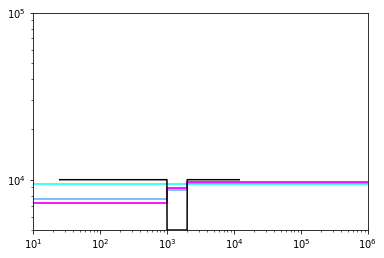

In [28]:
plotGradientTrajectory (sizeChangeTimes, truthData, eSteps, yLim=(5e3,1e5))

In [21]:
lls

[array([-2523679.59922047]), array([-2523679.59922047])]

E Step 0


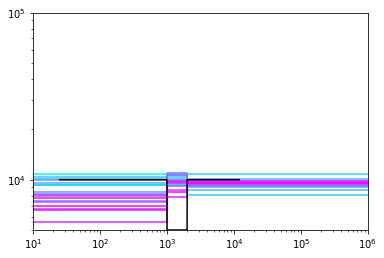

E Step 1


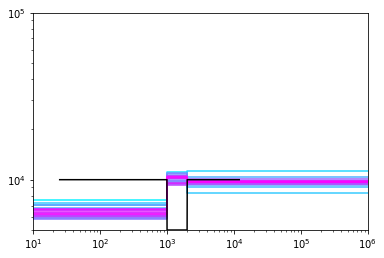

E Step 2


In [22]:
# all the trajectories
for (idx, v) in enumerate(optTrajectory):
    (eStep, mSteps) = v

    print (f"E Step {idx}")

    if (mSteps is not None):
        plotGradientTrajectory (sizeChangeTimes, truthData, mSteps, yLim=(5e3,1e5))